In [79]:
import re
import time
import nltk
import tweepy
import string
import numpy
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from nltk.tokenize import regexp_tokenize, sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

DATASET

In [70]:
news_tweets1 = pd.read_csv('david_labelled.csv')
news_tweets2 = pd.read_csv('transfer_news1_labelled.csv')
news_tweets3 = pd.read_csv('transferChecker_labelled.csv')

news_tweets = pd.concat([news_tweets1, news_tweets2, news_tweets3])

news_tweets.head()

,Unnamed: 0,Created at,User ID,Label,User Name,Text,Description,Location,Followers Count,Friends Count,Statuses Count,Profile Image Url
0,4,Mon Sep 19 21:42:39 +0000 2022,1.571980e+18,1,David Ornstein,🚨 Chelsea appointment of sporting director not...,"Football Correspondent, @TheAthleticUK",UK,1699313,1970,6861,http://pbs.twimg.com/profile_images/1178558529...
1,7,Sun Sep 18 20:15:27 +0000 2022,1.571590e+18,1,David Ornstein,🚨 Chelsea met with RB Leipzig chief Oliver Min...,"Football Correspondent, @TheAthleticUK",UK,1699313,1970,6861,http://pbs.twimg.com/profile_images/1178558529...
2,8,Sun Sep 18 19:45:44 +0000 2022,1.571590e+18,1,David Ornstein,🚨 EXCL: Everton open talks over new contract f...,"Football Correspondent, @TheAthleticUK",UK,1699313,1970,6861,http://pbs.twimg.com/profile_images/1178558529...
3,16,Thu Sep 15 11:52:55 +0000 2022,1.570380e+18,1,David Ornstein,🚨 Brentford striker Ivan Toney set to be named...,"Football Correspondent, @TheAthleticUK",UK,1699313,1970,6861,http://pbs.twimg.com/profile_images/1178558529...
4,21,Mon Sep 12 08:20:46 +0000 2022,1.569240e+18,1,David Ornstein,🚨 Arsenal head of emerging talent Yousuf Sajja...,"Football Correspondent, @TheAthleticUK",UK,1699313,1970,6861,http://pbs.twimg.com/profile_images/1178558529...


In [71]:
news_tweets['Text'] = news_tweets['User Name'].astype(str)+' '+news_tweets['Text'].astype(str)+' '+news_tweets['Description'].astype(str)
train_data = news_tweets[['Text', 'Followers Count', 'Label']]
train_data.head()

,Text,Followers Count,Label
0,David Ornstein 🚨 Chelsea appointment of sporti...,1699313,1
1,David Ornstein 🚨 Chelsea met with RB Leipzig c...,1699313,1
2,David Ornstein 🚨 EXCL: Everton open talks over...,1699313,1
3,David Ornstein 🚨 Brentford striker Ivan Toney ...,1699313,1
4,David Ornstein 🚨 Arsenal head of emerging tale...,1699313,1


TEXT PREPROCESSING

In [72]:

stop_words = stopwords.words('english')

def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#', "").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('quot;', "'").replace("@", '').replace('🚨', "").replace('🔵', '')
    return re1.sub(' ', x1)
    

def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)



def remove_stopwords(words, stop_words):
    """Remove stopwords"""
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])


def clean_text( text):
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = text.lower()
    # text = replace_numbers(text)
    words = word_tokenize(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

train_data['Text'] = train_data['Text'].apply(lambda x: clean_text(x))
train_data.head()
# train.sample(1)['Comment'].values[0]

C:\Users\HP\AppData\Local\Temp\ipykernel_20012\1374907274.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Text'] = train_data['Text'].apply(lambda x: clean_text(x))


,Text,Followers Count,Label
0,david ornstein chelsea appointment sport direc...,1699313,1
1,david ornstein chelsea meet rb leipzig chief o...,1699313,1
2,david ornstein excl everton open talk new cont...,1699313,1
3,david ornstein brentford striker ivan toney se...,1699313,1
4,david ornstein arsenal head emerge talent yous...,1699313,1


In [99]:
train_targ = train_data['Label']
train_param = train_data.drop(columns=['Label'])
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(train_param['Text'], train_targ, random_state = 33, test_size = .3)

In [100]:
count_vectorizer = CountVectorizer()

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
tfidf_train.shape

(171, 1384)

In [101]:
tfidf_nb = MultinomialNB()

# ... Train your model here ...
tfidf_nb.fit(tfidf_train, y_train)
# Run predict on your TF-IDF test data to get your predictions
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)

# Calculate the accuracy of your predictions
tfidf_nb_score = metrics.accuracy_score(y_test, tfidf_nb_pred)

# Create a MulitnomialNB model
count_nb = MultinomialNB()
# ... Train your model here ...
count_nb.fit(count_train, y_train)
# Run predict on your count test data to get your predictions
count_nb_pred = count_nb.predict(count_test)

# Calculate the accuracy of your predictions
count_nb_score = metrics.accuracy_score(y_test, count_nb_pred)

print('NaiveBayes Tfidf Score: ', tfidf_nb_score)
print('NaiveBayes Count Score: ', count_nb_score)

NaiveBayes Tfidf Score:  0.7162162162162162
NaiveBayes Count Score:  0.8243243243243243


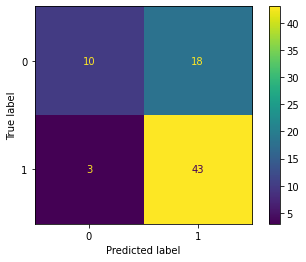

C:\Users\HP\AppData\Local\Temp\ipykernel_20012\239752540.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


<Figure size 432x288 with 0 Axes>

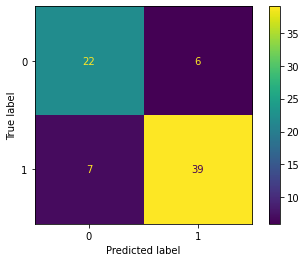

In [102]:
# Calculate the confusion matrices for the tfidf_nb model and count_nb models
tfidf_nb_cm = metrics.confusion_matrix(y_test, tfidf_nb_pred, labels=[0, 1])
count_nb_cm = metrics.confusion_matrix(y_test, count_nb_pred, labels=[0, 1])

# Plot the tfidf_nb_cm confusion matrix
metrics.ConfusionMatrixDisplay(tfidf_nb_cm, display_labels=[0, 1]).plot()
plt.show()

g = plt.figure(1)
# # Plot the count_nb_cm confusion matrix without overwriting the first plot 
metrics.ConfusionMatrixDisplay(count_nb_cm, display_labels=[0, 1]).plot()
g.show()

LinearSVC Score:   0.784


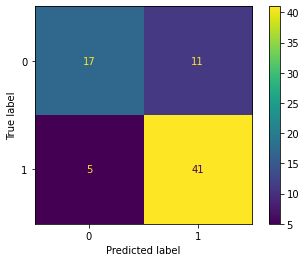

In [103]:
tfidf_svc = LinearSVC()

# ... Train your model here ...
tfidf_svc.fit(tfidf_train, y_train)
# Run predict on your tfidf test data to get your predictions
tfidf_svc_pred = tfidf_svc.predict(tfidf_test)

# Calculate your accuracy using the metrics module
tfidf_svc_score = metrics.accuracy_score(y_test,tfidf_svc_pred )

print("LinearSVC Score:   %0.3f" % tfidf_svc_score)

# Calculate the confusion matrices for the tfidf_svc model
svc_cm = metrics.confusion_matrix(y_test, tfidf_svc_pred, labels=[0, 1])

# Plot the confusion matrix using the plot_confusion_matrix function
metrics.ConfusionMatrixDisplay(svc_cm, display_labels=[0, 1]).plot()
plt.show()